This file is for analyzing already generated models with on **mock-data** and further training them on study data.

In [2]:
from hmmlearn import hmm
import pandas as pd
import os
import numpy as np
import pickle
import math
import matplotlib.pyplot as plt
import statsmodels.graphics.boxplots as st

In [3]:
"""
Appends the error values of the file(sequence) to X and the length of the sequence to the array lengths. 
The scores (labels of me and the study participants) will be saved in array scores.

@param filename: name of file/sequence
@param X: array of error values for all practice opportunities of one practice mode
@param lengths: array of lengths of the individual sequences
@param scores: array of scores/labels of each practice opportunity
"""
def get_sequence(filename, X, lengths, scores):
    file = pd.read_csv(filename)
    for i, row in file.iterrows():
        X.append(list(row[10:15])) #right hand: [4:9]  #change to 4: if all errors, now only right hand
        scores.append(list(row[:2]))
    lengths.append(len(file))
    return X, lengths, scores

In [4]:
"""
Appends SOME of the error values of the file(sequence) to X and the length of the sequence to the array lengths. 
The scores (labels of me and the study participants) will be saved in array scores.

@param filename: name of file/sequence
@param X: array of error values for all practice opportunities of one practice mode
@param lengths: array of lengths of the individual sequences
@param scores: array of scores/labels of each practice opportunity
"""
def get_sequences_one_hand(filename, X, lengths, scores):
    file = pd.read_csv(filename)
    skip = 0
    for i, row in file.iterrows():
        if "both" in row["level"]:
            skip += 1
        elif "left" in row["level"]:
            X.append([row[11], row[12]]) #choose here which errors to use
            scores.append(list(row[:2]))
        elif "right" in row["level"]:
            X.append([row[5], row[6]])
            scores.append(list(row[:2]))
    if (len(file)-skip) != 0:
        lengths.append(len(file)-skip)
    return X, lengths, scores

In [5]:
"""
Analysis of the scores/labels corresponding to the predicted state by the generated model.
Can print out mean, median, max, min for each label list.

@return data: scores/labels for each predicted state
@return dataName: name for visualization
"""
def analyse(model, X, lengths, scores):
    hidden_state = model.predict(X, lengths)
    index = 0
    for length in lengths:
        print(hidden_state[index:index+length]) #print predicted states
        index += length
    comp = []
    for e1, e2 in zip(hidden_state, scores):
        comp.append((e1,e2[0], e2[1]))
    mean_scores0 = []
    mean_scores1 = []
    my_scores0 = [] 
    my_scores1 = [] 
    their_scores0 = []
    their_scores1 = []
    for triple in comp:
        if not math.isnan(triple[1]):
            if triple[0] == 0:
                mean_scores0.append((triple[1] + triple[2])/2)
                my_scores0.append(triple[2])
                their_scores0.append(triple[1])
            elif triple[0] == 1:
                mean_scores1.append((triple[1] + triple[2])/2)
                my_scores1.append(triple[2])
                their_scores1.append(triple[1])
    data = []
    dataName = []
    for name, liste in [("mean_0", mean_scores0), ("mean_1", mean_scores1),
                         ("my_0", my_scores0), ("my_1", my_scores1),
                         ("their_0", their_scores0), ("their_1", their_scores1)]:
            if liste:
                mean = np.mean(liste)
                median = np.median(liste)
                maxL = np.max(liste)
                minL = np.min(liste)
                #print("mean", mean)
                #print("median", median)
                #print("maxL", maxL)
                #print("minL", minL)
                #print("")
                data.append(liste)
                dataName.append(name)
            else:
                print("Liste is empty", name)
    return data, dataName

In [6]:
"""
Main-File: Iterates over all practice modes and all generated models for that practice mode and prints out the
predicted state sequences, the score(logProb) and transition probability.
"""
pm_data = []
pm_names = []
csv_files = ["right hand","split hands", "both hands", "single note", "slower", "None",]
pkl_files = ["goodBadModel", "goodBadModel", "goodBadModel", "goodBadModel", "goodBadModel", "goodBadModel"]
#csv_files = ["split hands"]
#pkl_files = ["goodBadModel"]
for csv_file, pkl_file in zip(csv_files, pkl_files):
    lengths = []
    X = []
    scores = []
    for filename in os.listdir(csv_file):
        X, lengths, scores = get_sequence(csv_file + "/" + filename, X, lengths, scores)
    try:
        with open(pkl_file + ".pkl", "rb") as file:
            model = pickle.load(file)    
        print(csv_file)
        # Comment the following two lines in, to further train the models on teh study data
        #model.init_params=""
        #model.fit(X, lengths)
        data, dataName = analyse(model, X, lengths, scores)
        pm_data.append(data)
        pm_names.append(dataName)
        print("score", model.score(X, lengths))
        print("mean", model.means_)
        print("transition prob\n", model.transmat_)
        print("")#print(scores)
    except:
        print("Something went wong")

right hand
[0 1 1]
[0 1 1 1 1 1]
[0 1 1 1 1 1 1 1 1 1]
[0 1 1 1 1]
[0 1 1 1]
[0 1 1 1 1 1 1 1 1]
score -201.3115832774935
mean [[2.68292648e-01 3.33724368e+00 2.31540993e-01 1.67405743e-01
  4.54545405e-02]
 [2.49493305e-59 1.37765782e+00 2.42224892e-02 3.73570798e-59
  2.39234312e-03]]
transition prob
 [[0.82926831 0.17073169]
 [0.         1.        ]]

split hands
[0 1 1]
[0 0 0 1 1]
[0 0 1 1]
[0 0 0 0 0 0 0 0 0 0 1]
[0 1 1]
score -41.523507414174816
mean [[2.68292648e-01 3.33724368e+00 2.31540993e-01 1.67405743e-01
  4.54545405e-02]
 [2.49493305e-59 1.37765782e+00 2.42224892e-02 3.73570798e-59
  2.39234312e-03]]
transition prob
 [[0.82926831 0.17073169]
 [0.         1.        ]]

both hands
[0 1 1]
[0 1 1 1 1 1]
[0 1 1]
[0 1 1 1 1 1 1 1 1 1]
[0 0 0 1 1]
[0 0 1 1]
[0 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 1]
[0 1 1]
[0 1 1 1]
[0 1 1 1 1 1 1 1 1]
score -242.8350906916683
mean [[2.68292648e-01 3.33724368e+00 2.31540993e-01 1.67405743e-01
  4.54545405e-02]
 [2.49493305e-59 1.37765782e+00 2.42224

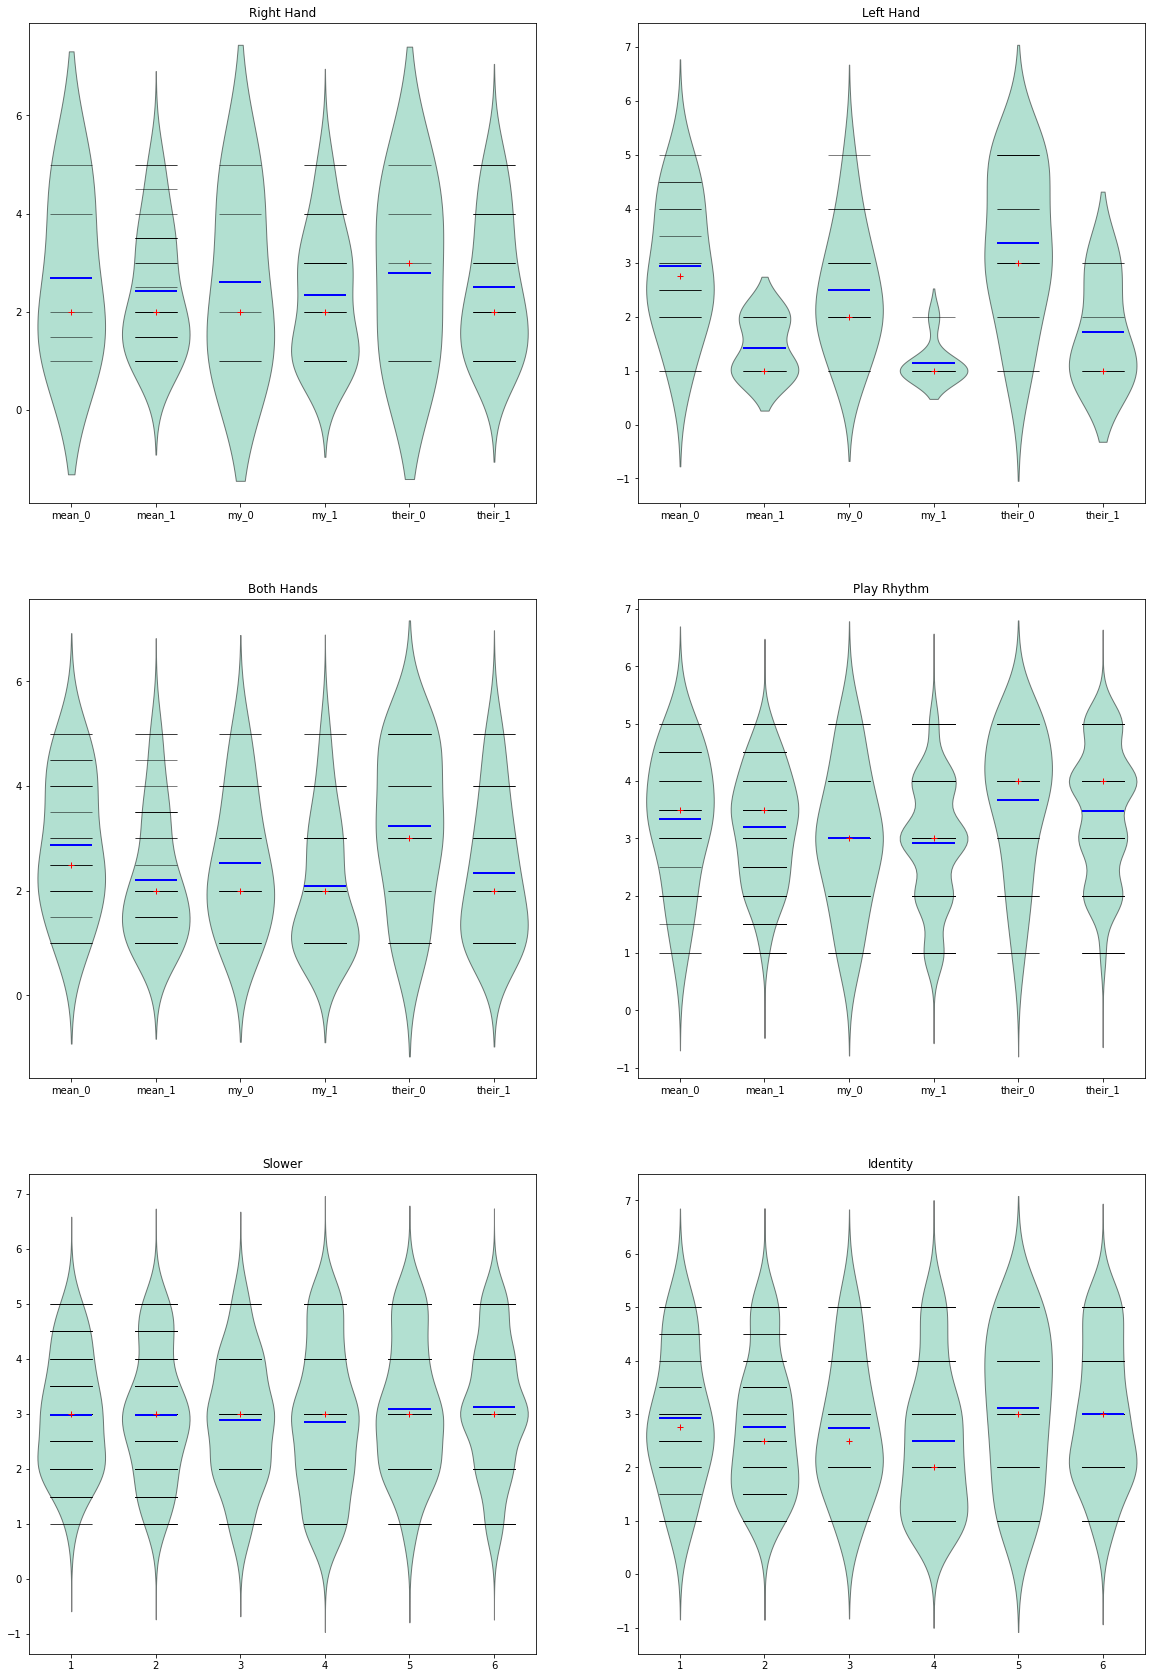

In [7]:
"""
This method displays bean plots for each generated model. The bean-plots refer to a state and show the 
distribution of scores/labels given by the study participants and myself for each practice opportunity.
"""
fig, ax = plt.subplots(3,2, figsize=(20,30))

st.beanplot(pm_data[0], ax=ax[0,0])
ax[0,0].set_title("Right Hand")
st.beanplot(pm_data[1], ax=ax[0,1])
ax[0,1].set_title("Left Hand")
st.beanplot(pm_data[2], ax=ax[1,0])
ax[1,0].set_title("Both Hands")
st.beanplot(pm_data[3], ax=ax[1,1])
ax[1,1].set_title("Play Rhythm")
st.beanplot(pm_data[4], ax=ax[2,0])
ax[2,0].set_title("Slower")
st.beanplot(pm_data[5], ax=ax[2,1])
ax[2,1].set_title("Identity")



ax[0,0].set_xticklabels(pm_names[0])
ax[0,1].set_xticklabels(pm_names[1])
ax[1,0].set_xticklabels(pm_names[2])
ax[1,1].set_xticklabels(pm_names[3])

#plt.savefig("BeanplotTwoStates.svg", bbox_inches='tight')
plt.savefig("BeanplotMockFurtherTrained.png", bbox_inches='tight')
#plt.savefig("BeanplotTwoStates.jpg", bbox_inches='tight')